# Logistic Classification

Logistic regression is a fundamental statistical learning technique which makes use of supervised machine learning methods for classification tasks. Parameters of linear regression equations are are optimised to give binary outputs (class labels) which minimise prediction error for a subset of the data. Predictive performance is then measured for the rest of the data which makes up the valuation set.

This notebook contains excerpts of the source code developed for the investigation into the use of a probabilistic linear classifier and plots for the class predictive probabilies obtained. A more in depth analysis of the results, including commentary on metrics such as log-likelihoods and predictive accuracies, can be found in the written reports.

### 2D Dataset

In [1]:
# Import the required Python modules
import numpy as np
import scipy
from scipy.optimize import fmin_l_bfgs_b
import seaborn as sb
import matplotlib.pyplot as plt

In [2]:
# Load the data
X = np.loadtxt('X.txt')
y = np.loadtxt('y.txt')

# Randomly permute the data
permutation = np.random.permutation(X.shape[ 0 ])
X = X[ permutation, : ]
y = y[ permutation ]

In [3]:
# Function that plots the points in 2D space, together with their labels
def plot_data_internal(X, y):
    x_min, x_max = X[ :, 0 ].min() - .5, X[ :, 0 ].max() + .5
    y_min, y_max = X[ :, 1 ].min() - .5, X[ :, 1 ].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    plt.figure()
    plt.xlim(xx.min(None), xx.max(None))
    plt.ylim(yy.min(None), yy.max(None))
    ax = plt.gca()
    ax.plot(X[y == 0, 0], X[y == 0, 1], 'ro', markersize = 3, label = 'Class 1')
    ax.plot(X[y == 1, 0], X[y == 1, 1], 'bo', markersize = 3, label = 'Class 2')
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.legend(loc = 'upper left', scatterpoints = 1, numpoints = 1)
    return xx, yy

# Function that plots the data without returning anything by calling "plot_data_internal"
def plot_data(X, y):
    xx, yy = plot_data_internal(X, y)
    plt.show()

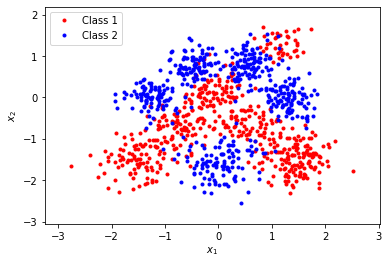

In [4]:
plot_data(X, y)

A classifier with a linear class boundary forms decision regions defined by a set of straight lines, as the decision boundary is orthogonal to the vector of parameters $\beta$. For the two class case of logistic regression, this decision boundary is a single straight line. There is little linear separation between each of the classes for the data shown in the plot of the data. Therefore, it cannot be separated into two decision regions consisting of outputs of a single class by a single straight line, indicating that a classifier with linear class boundaries is unlikely to perform well.

### Linear ML Classifier
For data assumed to have been generated under a probabilistic model, the maximum-likelihood (ML) estimate of parameters maximises the probability of observing the data given the paramers. Considering first the logistic classification model, the gradient of the log-likelihood given a vector of binary labels $\mathbf{y}$ and a matrix of input features $\mathbf{X}$ can be
written as:
\begin{split}
\frac{\partial\mathcal{L}(\beta)}{\partial\beta} &= \sum_{i=1}^{N}\frac{\partial\mathcal{L}(\beta)}{\partial\sigma^{(n)}}\frac{\partial\sigma^{(n)}}{\partial\beta}\\
&= \sum_{i=1}^{N} \frac{\left(y^{(n)} - \sigma^{(n)}\right)}{\sigma^{(n)}(1-\sigma^{(n)})}\cdot\tilde{\mathbf{x}}^{(n)}\sigma^{(n)}(1-\sigma^{(n)})\\
&=\sum_{i=1}^{N}\left(y^{(n)} - \sigma^{(n)}\right)\tilde{\mathbf{x}}^{(n)}
\end{split}\
The scalar term in this expression gives the prediction error for feature $\tilde{\mathbf{x}}^{(n)}$. Gradient ascent is a means of solving the optimisation problem of finding the parameters $\beta$ that minimise the prediction error for a set of training data. This is done through iteratively stepping up the objective $\mathcal{L}(\beta)$, as the gradients point up the hill, until a convergence criteria is reached or time runs out. 

In [44]:
# Split the data into a training and test set in the ratio 800:200
n_train = 800
X_train = X[ 0 : n_train, : ]
X_test = X[ n_train :, : ]
y_train = y[ 0 : n_train ]
y_test = y[ n_train : ]

In [45]:
# Define the logistic sigmoid function
def logistic(x): return 1.0 / (1.0 + np.exp(-x))

# Funciton to make predictions using the logistic classifier
def predict(X_tilde, w): return logistic(np.dot(X_tilde, w))

# Expand the matrix of input features by adding a column equal to 1
def get_x_tilde(X): return np.concatenate((np.ones((X.shape[ 0 ], 1 )), X), 1)

# Calculate the average log-likelihood (ll) for the data
def compute_average_ll(X_tilde, y, w):
    output_prob = predict(X_tilde, w)
    return np.mean(y * np.log(output_prob) + (1 - y) * np.log(1.0 - output_prob))


In [46]:
# Function that finds the model parameters by optimising the ll using gradient ascent
def fit_w(X_tilde_train, y_train, X_tilde_test, y_test, n_steps, alpha):
    # Initialise starting weights
    w = np.random.randn(X_tilde_train.shape[ 1 ])
    ll_train = np.zeros(n_steps)
    ll_test = np.zeros(n_steps)
    
    # Gradient ascent
    for i in range(n_steps):
        sigmoid_value = predict(X_tilde_train, w)
        w = w + alpha * np.dot(X_tilde_train.T, y_train - sigmoid_value)
        ll_train[ i ] = compute_average_ll(X_tilde_train, y_train, w)
        ll_test[ i ] = compute_average_ll(X_tilde_test, y_test, w)
    return w, ll_train, ll_test

# Function that plots the average log-likelihood returned by "fit_w"
def plot_ll(ll,two):
    plt.figure()
    ax = plt.gca()
    plt.xlim(0, len(ll) + 2)
    plt.ylim(min(ll) - 0.1, max(ll) + 0.1)
    ax.plot(np.arange(1, len(ll) + 1), ll, 'r-',label = 'Training data')
    ax.plot(np.arange(1, len(ll) + 1), two, 'b-', label = 'Test data')
    plt.xlabel('Steps')
    plt.ylabel('Average log-likelihood')
    plt.legend()
    plt.show()
    print('Final training log likelihood =', round(ll_train[-1], 4))
    print('Final test log likelihood =', round(ll_test[-1], 4))

# Function that plots the predictive probabilities of the logistic classifier
def plot_predictive_distribution(X, y, w, map_inputs = lambda x : x):
    xx, yy = plot_data_internal(X, y)
    ax = plt.gca()
    X_tilde = get_x_tilde(map_inputs(np.concatenate((xx.ravel().reshape((-1, 1)), yy.ravel().reshape((-1, 1))), 1)))
    Z = predict(X_tilde, w)
    Z = Z.reshape(xx.shape)
    cs2 = ax.contour(xx, yy, Z, cmap = 'RdBu', linewidths = 2)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize = 14)
    plt.title('Class predictive probability contours')
    plt.show()

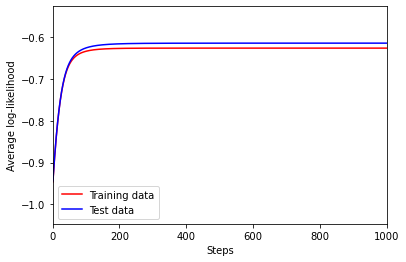

Final training log likelihood = -0.6259
Final test log likelihood = -0.614


In [47]:
# Train the linear classifier with a learning rate of 0.0001 over 1000 steps
alpha = 0.0001
n_steps = 1000

X_tilde_train = get_x_tilde(X_train)
X_tilde_test = get_x_tilde(X_test)
w, ll_train, ll_test = fit_w(X_tilde_train, y_train, X_tilde_test, y_test, n_steps, alpha)
# Plot the variation of ll with training steps
plot_ll(ll_train,ll_test)

Inspection of these plots confirms that an appropriate learning rate was chosen: the average log-likelihood of the training data increased with number of steps and converged to its maximum. Furthermore, no oscillatory behaviour (which would indicate divergence from the maximum) was present. Hence, the maximum-likelihood estimate of the parameters $\beta$ was successfully found through gradient ascent.

Results for the average log-likelihoods of the training and test data vary similarly over the optimisation process, demonstrating that the maximum likelihood estimate generated by the model performs comparably for the two data sets. This suggests that the classifier has not overfit to the training data.

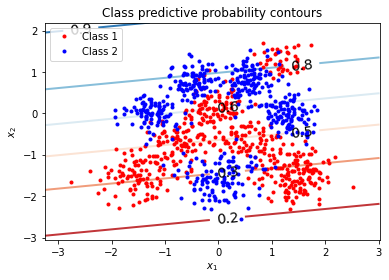

In [48]:
# Plot the class predictive distribution
plot_predictive_distribution(X, y, w)

This figure further highlights the limitations of a linear classifier for this dataset. Predictive linear probability contours for the trained model run through regions containing data from both classes. Therefore, decision boundaries do not encapsulate the clustered nature of the data. Applying a threshold to the probabilistic predictions so that those greater than $\tau = 1/2$ are assigned a positive predicted class label $\hat{y}= 1$ and those equal or below are assigned to a negative predictive class label $\hat{y}= 0$, the plot shows that a significant portion of data above and below the 0.5 contour is wrongly predicted as false positives and false negatives.

### Non-Linear ML Classifier
Clearly, non-linear decision boundaries are required. The use of non-linear basis functions allows for such decision boundaries, without a change to the inference. The inputs were expanded through a set of non-linear Gaussian radial basis functions (RBFs) centred on the training datapoints. The feature-expanded inputs took the form $\tilde{x}_1^{(n)} = 1$ (to handle the bias terms as before) and:
$$  \tilde{x}_{m+1}^{(n)} = \exp \left(-\frac{1}{2 \mathrm{l}^{2}} \sum_{\mathrm{d}=1}^{2}\left(\mathrm{x}_{\mathrm{d}}^{(\mathrm{n})}-\mathrm{x}_{\mathrm{d}}^{(\mathrm{m})}\right)^{2}\right)$$
such that the $(m+1)^{\text{th}}$ feature is given by a radial basis function centred on the $m^{\text{th}}$ training datapoint, with width $l$.

In [49]:
# Function to feature-expand the input data using RBFs
def evaluate_basis_functions(l, X, Z):
    X2 = np.sum(X**2, 1)
    Z2 = np.sum(Z**2, 1)
    ones_Z = np.ones(Z.shape[ 0 ])
    ones_X = np.ones(X.shape[ 0 ])
    r2 = np.outer(X2, ones_Z) - 2 * np.dot(X, Z.T) + np.outer(ones_X, Z2)
    return np.exp(-0.5 / l**2 * r2)

In [50]:
# Feature expand the data
l = 0.1
X_tilde_train = get_x_tilde(evaluate_basis_functions(l, X_train, X_train))
X_tilde_test = get_x_tilde(evaluate_basis_functions(l, X_test, X_train))

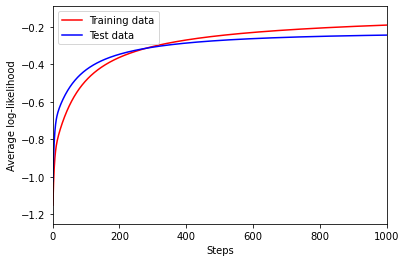

Final training log likelihood = -0.1899
Final test log likelihood = -0.2434


In [51]:
# Train the model with a learning rate of 0.001 over 1000 steps
alpha = 0.001
n_steps = 1000

w, ll_train, ll_test = fit_w(X_tilde_train, y_train, X_tilde_test, y_test, n_steps, alpha)
plot_ll(ll_train,ll_test)

The results of this plot indicate that the classifier with width parameter $l=0.1$ still overfits to the training data, as the average final log-likelihood for the training data is approximately a factor of 1.5 greater than the test data. This difference demonstrates that the classifier performs significantly better on the training set compared to valuation set. This notion is confirmed by inspecting the class predictive probability contours as follows.

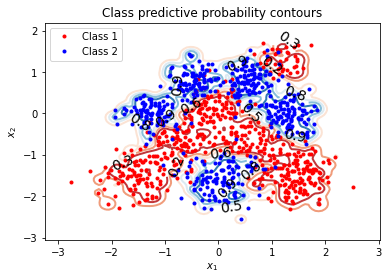

In [52]:
plot_predictive_distribution(X, y, w, lambda x : evaluate_basis_functions(l, x, X_train))

This plot reveals a set of contours which closely follow the positions of individual datapoints. Supposing the data was generated through a process which involved the addition of random noise, by fitting closely to each datapoint the model has trained itself to the detail of the noise. This impairs its performance on newly seen data, such as that from the test set. Overfitting can be avoided through use of a regulariser, which penalises the magnitude of the parameters and so discourages the model from using extreme weights, or by increasing the RBF width.

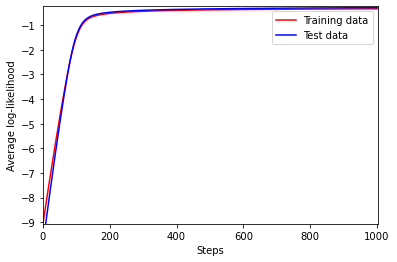

Final training log likelihood = -0.3331
Final test log likelihood = -0.2847


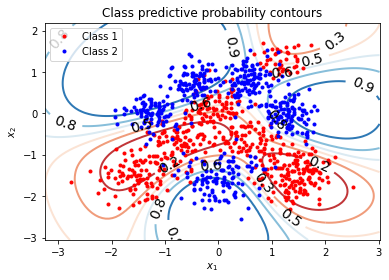

In [53]:
# Feature expand the data with a RBF width of 1
l = 1
X_tilde_train = get_x_tilde(evaluate_basis_functions(l, X_train, X_train))
X_tilde_test = get_x_tilde(evaluate_basis_functions(l, X_test, X_train))

# Train the model with a learning rate of 0.00001 over 1000 steps
alpha = 0.00001
n_steps = 1000
w, ll_train, ll_test = fit_w(X_tilde_train, y_train, X_tilde_test, y_test, n_steps, alpha)
plot_ll(ll_train,ll_test)
plot_predictive_distribution(X, y, w, lambda x : evaluate_basis_functions(l, x, X_train))

The average log-likelihoods were of a similar order for the training and test sets for a RBF width $l=1$. The contour plot also shows smooth class predictive probabilities distributions which vary from 0 to 1 at the boundaries between regions containing data belonging to different classes. From these observations, we can conclude that the classifier has not overfit to the training data. If anything, the model has slightly underfit: sharper probability transitions at the boundaries would yield improved predictive results. Hence, an appropriate choice of parameter $l$ would lie somewhere between 0.1 and 1.

A suitable width can be determined by analysing the predictive probability contour plot, average log-likelihoods for the training and test datasets and the predictive performance of the classifier from the confusion matrix, as explained in the 'Short Report'.

### Bayesian Classifier
Without a regulariser which penalises large magnitudes of parameter weights, or prior which enforces the parameters to be small, there is no provision to stop the ML model overfitting to the training data.

The task of logistic classification was extended by incorporating a prior over the parameters of the model in conjunction with the likelihood function. By selecting a prior distribution which favours smaller parameters $\boldsymbol{\beta}$, the prior has a 'regularising' effect on the likelihood, reducing the degree of over fitting compared to the ML case.

Since the Bayesian posterior distribution and its corresponding predictive distribution are intractable, a Laplace approximation was employed for a Gaussian estimate of the posterior distribution to be formed. The logarithm of this distribution was maximised to obtain the maximum a posterior (MAP) point estimate of the parameters. A second set of approximations were performed, giving an approximate Bayesian predictive distribution. 

(For derivations of the Laplace approximation and subsequent log-likelihood terms, refer to the 'Full Technical Report')

In [54]:
# Function which calculates the -ve of the logarithm of the posterior distribution (L*)
def post(w, *args):
    prior_var, X, y = args[0],args[1],args[2]
    sigmoid = predict(X, w)
    L = np.dot(y, np.log(sigmoid)) + np.dot((1 - y), np.log(1 - sigmoid))
    if prior_var != 0:
        L -= 1 / (2 * prior_var) * w.T @ w
    return -L

# Function which calculates the -ve of the gradient of L*
def post_grad(w, *args):
    prior_var, X = args[0],args[1]
    sigmoid = predict(X, w)
    dL = np.dot(X_tilde_train.T, y_train - sigmoid)
    if prior_var != 0:
        dL -= 1/prior_var * w
    return -dL

The MAP solution was obtained through use of the SciPy library function 'scipy.optimize.fmin_l_bfgs_b'. This function takes an objective function and its first derivative as arguments, and performs gradient based minimisation, returning an estimate of the position and value of the minimum. Since the MAP estimate maximises the log of the posterior $\mathcal{L^*}(\boldsymbol{\beta})$, the SciPy function was implemented with objective function $-\mathcal{L^*}(\boldsymbol{\beta})$ and first derivative $-\frac{\partial\mathcal{L^*}(\beta)}{\partial\beta}$, determined from the functions 'post' and 'post_grad' respectively.

In [55]:
#Function which returns the MAP estimate of the parametrs
def map(prior_var, X, y, n_steps):
    # Initialse starting weights
    w = np.random.randn(X.shape[1])
    w_map = scipy.optimize.fmin_l_bfgs_b(func=post, x0=w, fprime=post_grad, args=(prior_var, X, y), maxiter=n_steps)
    return w_map[0]

In [56]:
# Function which returns the covariance matrix of the Laplace approximation, calculated as the inverse of the Hessian
def covariance(w, prior_var, X):
    sigmoid = predict(X, w)
    scalar = sigmoid - sigmoid * sigmoid
    hess = 1 / prior_var * np.identity(X.shape[1])
    for x, y in zip(X, scalar):
        hess += y * np.outer(x, x)
    s_n = np.linalg.inv(hess)
    return s_n 

# Approximated Bayesian predictive distribution
def bayesian_predictive(X, w_map, s_n):
    mu = X @ w_map
    var = np.diag(X @ (s_n @ X.T))
    den = 1 + 1/8 * np.pi * var ** 2
    k_prob = mu * den ** -0.5
    return logistic(k_prob)

# Function which returns the ll of the Bayesian model
def bayesian_ll(X, y, w_map,S_n):
    output_prob = bayesian_predictive(X,w_map,S_n)
    return np.mean(y * np.log(output_prob) + (1 - y) * np.log(1.0 - output_prob))

# Funciton which plots the class predictive contours of the Bayesian model
def plot_bayesian_distribution(X, y, w, s_n, map_inputs = lambda x : x):
    xx, yy = plot_data_internal(X, y)
    ax = plt.gca()
    X_tilde = get_x_tilde(map_inputs(np.concatenate((xx.ravel().reshape((-1, 1)), yy.ravel().reshape((-1, 1))), 1)))
    Z = bayesian_predictive(X_tilde, w, s_n)
    Z = Z.reshape(xx.shape)
    cs2 = ax.contour(xx, yy, Z, cmap = 'RdBu', linewidths = 2)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize = 14)
    plt.title('Bayesian class predictive probability contours')
    plt.show()

In [57]:
# Use a prior with variance 1, and optimise the MAP estimate over 1000 iterations
prior_var = 1
map_steps = 1000

w_map = map(prior_var,X_tilde_train,y_train,map_steps)
S_n = covariance(w_map, prior_var, X_tilde_train)

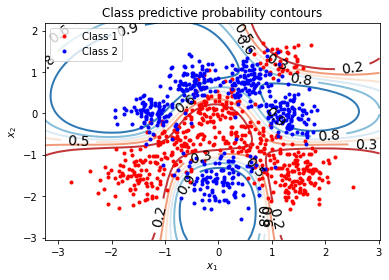

Final training log likelihood = -0.2236
Final test log likelihood = -0.1768


In [58]:
#plot the MAP predictive distribution
plot_predictive_distribution(X, y, w_map, lambda x : evaluate_basis_functions(l, x, X_train))
ll_train = compute_average_ll(X_tilde_train, y_train, w_map)
ll_test = compute_average_ll(X_tilde_test, y_test, w_map)
print('Final training log likelihood =', round(ll_train, 4))
print('Final test log likelihood =', round(ll_test, 4))

Like the ML estimate, the MAP method returns a point estimate of the parameters. However, the MAP estimate is formed through use of the likelihood function as well as a prior distribution over the parameters, thus exhibiting a lower degree of overfitting. 

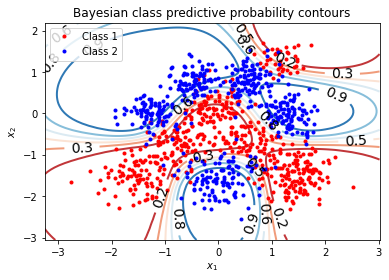

Final training log likelihood = -0.2262
Final test log likelihood = -0.1808


In [59]:
#plot the Bayesisan predictive distribution
plot_bayesian_distribution(X, y, w_map, S_n, lambda x : evaluate_basis_functions(l, x, X_train))
ll_train = bayesian_ll(X_tilde_train, y_train, w_map, S_n)
ll_test = bayesian_ll(X_tilde_test, y_test, w_map, S_n)
print('Final training log likelihood =', round(ll_train, 4))
print('Final test log likelihood =', round(ll_test, 4))

The MAP estimate produces predictive contours which are constant along the decision border. A Bayesian approach yields a predictive distribution with increased uncertainty in regions where there is less data, the uncertainty being linked to the variance of the distribution in the corresponding region.

As the training set used to fit the model was relatively large (N=800), the prior has little influence on the shape of the posterior density, giving Bayesian class predictive probability contours similar to that of the MAP case. An in-depth explanation for this notion can be found in the 'Full Technical Report'.

### Hyperparameter Tuning
The optimal hyper-parameters $(l^*,\sigma_0^*)$ are those which maximise the model evidence.

In [60]:
# Function which calculates the model evidence (ME) for given parameters, Hessian and dataset
def model_evidence(w_map, S_n, X, y, prior_var, N):
    # log-likelihood - prior term - map term
    p_x = - post(w_map, 0, X, y) - N / 2 * np.log(prior_var) - 1 / (2 * prior_var) * w_map.T @ w_map
    (sign, logdet) = np.linalg.slogdet(S_n)
    # cov term
    p_x -= 0.5 * np.abs(logdet)
    return p_x

A grid search method was used to find the optimal parameters of the Bayesian predictive model. A heat map was generated through use of the Seaborn library function 'seaborn.heatmap'.

In [61]:
# Function which calculates the model evidence (ME) for the various cominations of l and sigma
def heat_map(X_train, y_train, l, prior_var, n_train, n_steps):
    me = []
    for i in range(len(l)):
        X_tilde_train = get_x_tilde(evaluate_basis_functions(l[i], X_train, X_train))
        me_l = []
        for j in range(len(prior_var)):
            w_map = map(prior_var[j], X_tilde_train, y_train, n_steps)
            S_n = covariance(w_map, prior_var[j], X_tilde_train)
            me_l.append(model_evidence(w_map,S_n,X_tilde_train,y_train,prior_var[j], n_train))
        me.append(me_l)
    me = np.array(me)
    # The combination of l and sigma which maximise the ME are the optimal hyperparameters
    index = np.unravel_index(me.argmax(), me.shape)
    l_opt = l[index[0]]
    prior_var_opt = prior_var[index[1]] ** 2
    hplot = sb.heatmap(me, yticklabels=np.round(l, 3), xticklabels=np.round(prior_var, 3),cbar_kws={'label': 'Model evidence'})
    plt.ylabel(r'$l$')
    plt.xlabel(r'$\sigma_{0}^2$')
    return l_opt, prior_var_opt, hplot

# Function which plots the grid
def plot_heat_map(X_train, y_train, l, prior_var, n_train, n_steps):
    l_opt, prior_var_opt, hplot = heat_map(X_train, y_train, l, prior_var, n_train, n_steps)
    plt.show()
    return l_opt, prior_var_opt

/Users/SanchitGandhi/anaconda3/envs/pt12/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


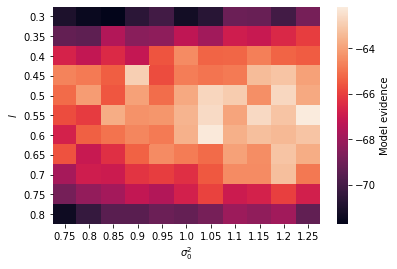

In [43]:
# Optimise over a 10 x 10 grid
l = np.linspace(0.3, 0.8, 11)
prior_var = np.linspace(0.75, 1.25, 11)

l_opt, prior_var_opt = plot_heat_map(X_train, y_train, l, prior_var, n_train, n_steps)

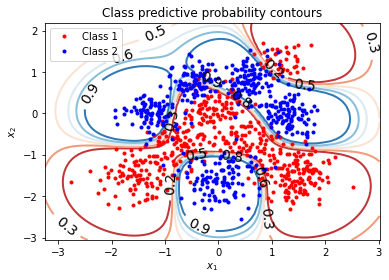

Final training log likelihood = -0.2183
Final test log likelihood = -0.172


In [62]:
w_map = map(prior_var_opt, X_tilde_train, y_train, map_steps)
S_n = covariance(w_map, prior_var_opt, X_tilde_train)

# Plot the MAP predictive distribution with the optimal hyperparameters
plot_predictive_distribution(X, y, w_map, lambda x : evaluate_basis_functions(l_opt, x, X_train))
ll_train = compute_average_ll(X_tilde_train, y_train, w_map)
ll_test = compute_average_ll(X_tilde_test, y_test, w_map)
print('Final training log likelihood =', round(ll_train, 4))
print('Final test log likelihood =', round(ll_test, 4))

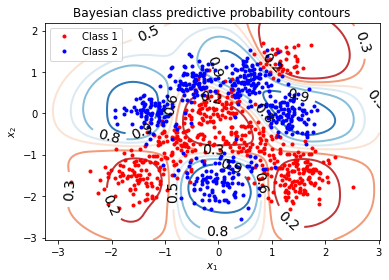

Final training log likelihood = -0.2226
Final test log likelihood = -0.1785


In [63]:
# Plot the Bayesisan predictive distribution with the optimal hyperparameters
plot_bayesian_distribution(X, y, w_map, S_n,lambda x : evaluate_basis_functions(l_opt, x, X_train))
ll_train = bayesian_ll(X_tilde_train, y_train, w_map, S_n)
ll_test = bayesian_ll(X_tilde_test, y_test, w_map, S_n)
print('Final training log likelihood =', round(ll_train, 4))
print('Final test log likelihood =', round(ll_test, 4))

Compared to the contours of the class predictive probabilities with the un-tuned hyper-parameters, both the MAP and Bayesian models exhibit a much lower degree of over fitting. As the RBF width was increased from 0.1 to 0.5, the basis functions better leverage information between data points, giving a set of wider-spread contours. With a smaller variance, the prior distribution also has a greater 'regularising' effect on the likelihood, favouring smaller parameters $\boldsymbol{\beta}$. The combination of these two factors results in less fitting to individual data points, giving class predictive probabilities that better encapsulate the wider distribution of data. More evident than before is the effect of uncertainty in the Bayesian case where less data is observed. Compared to the MAP estimate model, which produces contours constant along the decision border, the Bayesian predictive probability contours are more spread in regions containing less data.